# KITTI Dataset Exploration

In [1]:
!pip install moviepy
!pip install numpy
!pip install pykitti

In [2]:
## prerequisites

#!pip3 install pykitti
#!pip3 install moviepy

# download the synced and rectified dataset. do not need the unsynced dataset
#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip

#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_tracklets.zip


In [3]:
# unzip files
#import zipfile
#targetdir = "KITTI_data"
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_sync.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [4]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_calib.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [5]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_tracklets.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [6]:
import numpy as np
import pykitti

# Change this to the directory where you store KITTI data
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [7]:
from source import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    #print(xml_path)
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        print(tracklets)
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

Load the dataset downloaded from [KITTI website](http://www.cvlibs.net/datasets/kitti/raw_data.php). 

[2011_09_26_drive_0001 (0.4 GB)](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)

* **Length**: 114 frames (00:11 minutes)
* **Image resolution**: `1392 x 512` pixels
* **Labels**: 12 Cars, 0 Vans, 0 Trucks, 0 Pedestrians, 0 Sitters, 2 Cyclists, 1 Trams, 0 Misc

In [8]:
date = '2011_09_26'
drive = '0048'
dataset = load_dataset(date, drive)


directory = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(directory,date, date, drive))


Drive: 2011_09_26_drive_0048_sync

Frame range: None
Parsing tracklet file /Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.
[<source.parseTrackletXML.Tracklet object at 0x10784fda0>, <source.parseTrackletXML.Tracklet object at 0x10784fdd8>, <source.parseTrackletXML.Tracklet object at 0x10784fe10>, <source.parseTrackletXML.Tracklet object at 0x10784fe48>, <source.parseTrackletXML.Tracklet object at 0x10784fe80>, <source.parseTrackletXML.Tracklet object at 0x10784feb8>, <source.parseTrackletXML.Tracklet object at 0x10784fef0>, <source.parseTrackletXML.Tracklet object at 0x10784ff28>]
[<source.parseTrackletXML.Tracklet object at 0x10784fda0>, <source.parseTrackletXML.Tracklet object at 0x10784fdd8>, <source.parseTrackletXML.Tracklet object at 0x10784fe10>, <source.parseTrackletXML.Tracklet object at 0x10784fe48>, <source.parseTrackletXML.Tracklet ob

Looking at the points distributions, we could catch something meaningful if we limit **X**, **Y** and **Z** axis to some magic numbers.

Additionally we will only visualise 20% of the point cloud, as each frame contains ~120K points.

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

In [10]:
    #print(dataset.oxts)
    #print(velo_frame)
#    print(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
#print(type(ax)) # this is a numpy array
#print(velo_frame[:, 3])

import matplotlib.pyplot as plt

# 0 probably y
# 1 probably x
# 2 probably z

#velo_frame_test = velo_frame
#velo_frame_test[:, 3]=velo_frame[:, 3]*10
#plt.plot(velo_frame_test[:, 0],velo_frame_test[:, 3])
#plt.show()

# this seems correlated with the colors. the nearer the distance the higher the color. the further away the shorter the distance

In [11]:
frame = 10
dataset_velo = list(dataset.velo)
points = 0.8 # this controls the sampling rate
points_step = int(1. / points)
point_size = 0.01 * (1. / points)

velo_range = range(0, dataset_velo[10].shape[0], points_step)
velo_frame = dataset_velo[frame][velo_range, :] 
velo_frame_test = velo_frame
velo_frame_test[:, 3]=velo_frame[:, 3]*10
velo_range = range(0, dataset_velo[frame].shape[0], points_step)
velo_frame = dataset_velo[frame][velo_range, :]  
velo_frame = velo_frame_test

type(velo_frame)

velo_frame[velo_frame[:, 2]>0,2] = 10
#print(velo_frame[0:3,:])
print(velo_frame[velo_frame[:, 2]>0])

#velo_frame[velo_frame[:, 3]<=0] = 2


[[ 73.89    7.028  10.      0.   ]
 [ 73.892   7.263  10.      0.   ]
 [ 74.014   7.51   10.      0.   ]
 ..., 
 [ -0.896   2.154  10.      1.8  ]
 [ -0.905   2.148  10.      2.2  ]
 [ -0.406   2.135  10.      2.5  ]]


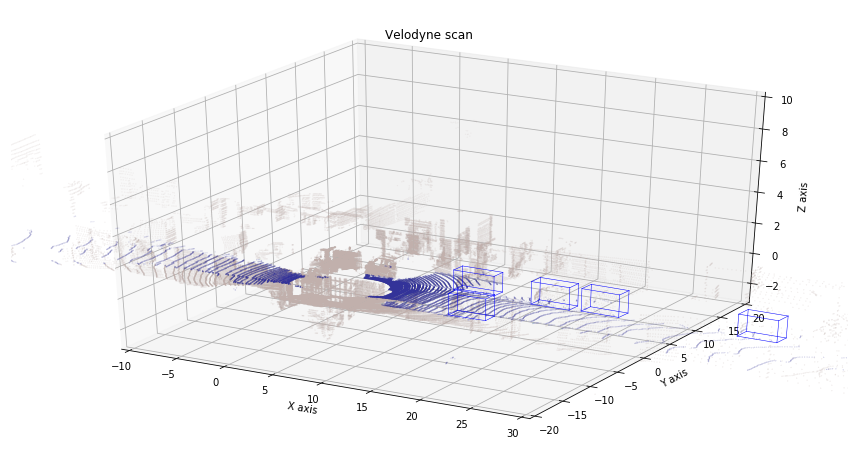

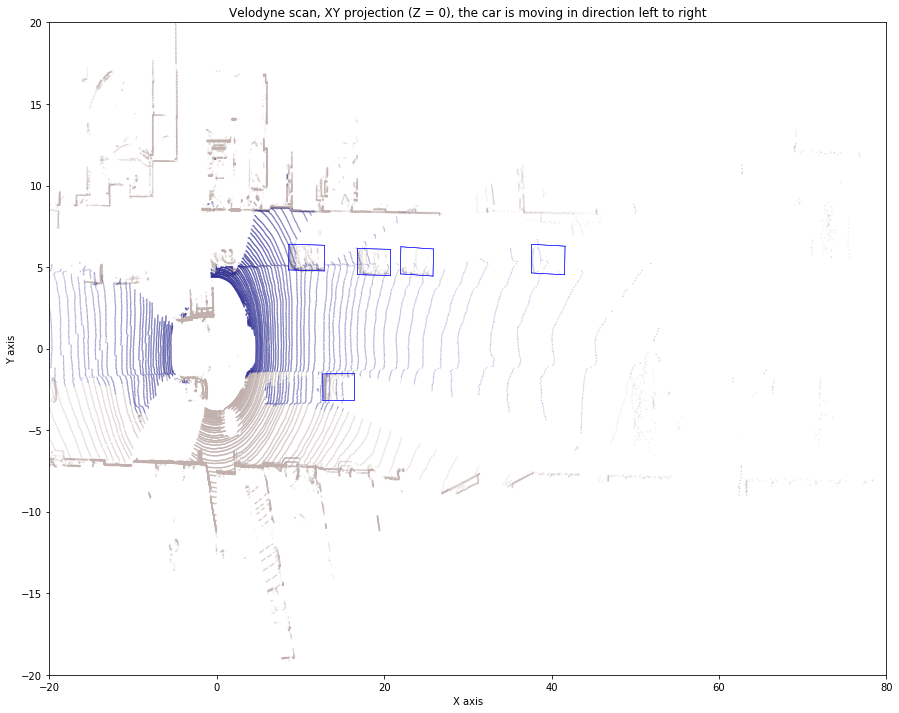

In [35]:
## just show the 3d plot

## this is a naive model based on height

#load the data
frame = 10
dataset_velo = list(dataset.velo)
points = 0.8 # this controls the sampling rate
points_step = int(1. / points)
point_size = 0.01 * (1. / points)

velo_range = range(0, dataset_velo[10].shape[0], points_step)
velo_frame = dataset_velo[frame][velo_range, :] 
velo_frame_test = velo_frame
velo_frame_test[:, 3]=velo_frame[:, 3]*10
velo_range = range(0, dataset_velo[frame].shape[0], points_step)
velo_frame = dataset_velo[frame][velo_range, :]  
velo_frame = velo_frame_test

velo_frame[velo_frame[:, 2]>-1.7,3] = 5
velo_frame[velo_frame[:, 2]<-1.7,3] = 0



def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    velo_frame
    ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    #ax.patch.set_facecolor('black')
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(ax, t_rects, axes=axes, color=colors[t_type])


        
# Draw point cloud data as 3D plot
f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')                    
draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
plt.show()

f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
draw_point_cloud(
    ax3, 
    'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
    axes=[0, 1] # X and Y axes
)
plt.show()


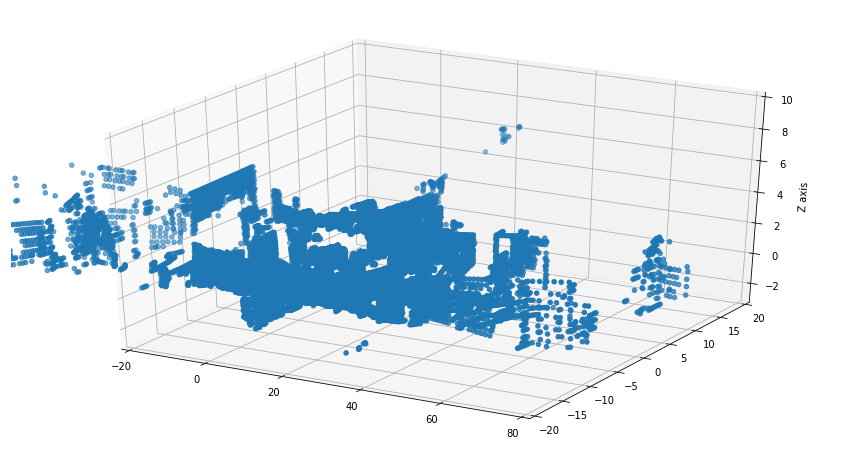

In [13]:
axes=[0, 1, 2]
np.transpose(velo_frame[:, axes])

f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')   
ax2.scatter3D(velo_frame[:, 0],velo_frame[:, 1],velo_frame[:, 2])
ax2.set_xlim3d(*axes_limits[axes[0]])
ax2.set_ylim3d(*axes_limits[axes[1]])
ax2.set_zlim3d(*axes_limits[axes[2]])
ax2.set_zlabel('{} axis'.format(axes_str[axes[2]]))
plt.show()

In [32]:
import random

def run_ransac(data_raw, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    best_ic = 0
    best_model = None
    random.seed(random_seed)
    data = data_raw[:,0:3]
    for i in range(max_iterations):
        #s = random.sample(data, int(sample_size))
        s = data[np.random.randint(data.shape[0], size=sample_size), :]
        #print("shape s: %",s.shape)
        m = estimate(s)
        ic = 0
        for j in range(len(data)):
            if is_inlier(m, data[j]):
                ic += 1
                #mark point as inline
                data_raw[j][3] = 0
                
            else:
                data_raw[j][3] = 5

        #print (s)
        print ('estimate:', m)
        print ('# inliers:', ic)

        if ic > best_ic:
            best_ic = ic
            best_model = m
            if ic > goal_inliers and stop_at_goal:
                break
    print ('took iterations:', i+1, 'best model:', best_model, 'explains:', best_ic)
    return best_model, best_ic,data_raw


import numpy as np
from matplotlib import pyplot as plt
#from ransac import *


def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz


def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]


def is_inlier(coeffs, xyz, threshold):
	return np.abs(coeffs.dot(augment([xyz]).T)) < threshold
	
	
if __name__ == '__main__':
	from matplotlib import pylab
	from mpl_toolkits import mplot3d
	fig = pylab.figure()
	ax = mplot3d.Axes3D(fig)
	
	
def plot_plane(a, b, c, d):
    #xx, yy = np.mgrid[:10, :10]
    xx, yy = np.mgrid[-20:80, -20:20]
    return xx, yy, (-d - a * xx - b * yy) / c
		
		
#n = 100
n = velo_frame.shape[0] * 0.1
max_iterations = 100
goal_inliers = n * 0.3

In [31]:
print(velo_frame.shape)

(116006, 4)


estimate: [-0.0468 -0.0704  0.6628  0.744 ]
# inliers: 1173
estimate: [-0.1734  0.2293 -0.1319  0.9486]
# inliers: 628
estimate: [ 0.2184 -0.2156  0.1318  0.9426]
# inliers: 630
estimate: [ 0.043   0.0321  0.6704  0.74  ]
# inliers: 1070
estimate: [-0.043  -0.1023  0.5862  0.8025]
# inliers: 873
estimate: [ 0.1609 -0.3875 -0.4535  0.7863]
# inliers: 808
estimate: [-0.0727 -0.1718  0.9331  0.3074]
# inliers: 842
estimate: [ 0.3765 -0.1534 -0.6956  0.5924]
# inliers: 496
estimate: [ 0.0135  0.0102  0.9488  0.3155]
# inliers: 798
estimate: [-0.0221  0.0708  0.6798  0.7297]
# inliers: 865
estimate: [-0.0241 -0.0732  0.5665  0.8205]
# inliers: 1293
estimate: [-0.0003 -0.1608  0.9743  0.1575]
# inliers: 252
estimate: [-0.0005  0.0161  0.4949  0.8688]
# inliers: 19097
took iterations: 13 best model: [-0.0005  0.0161  0.4949  0.8688] explains: 19097
plotting chart


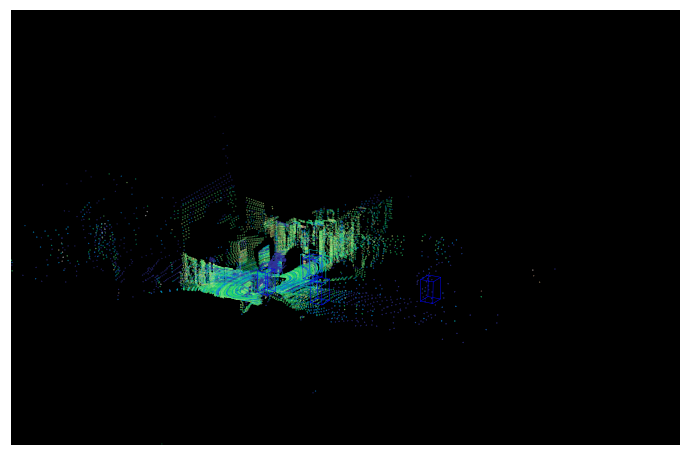

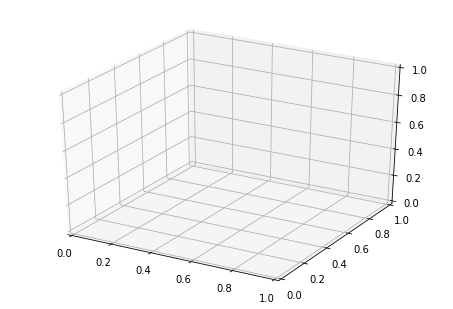

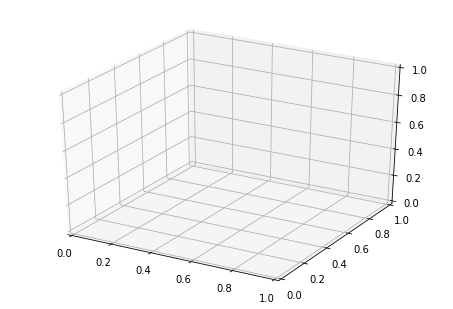

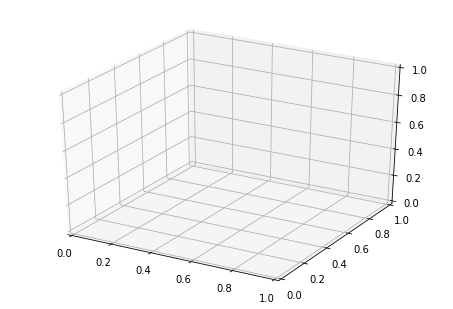

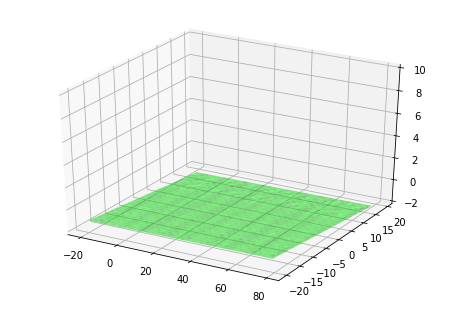

In [33]:
#%matplotlib inline
#m, b, adj_velo_frame = run_ransac(velo_frame[:,0:3], estimate, lambda x, y: is_inlier(x, y, 0.01), int(velo_frame.shape[0] * 0.1), goal_inliers, max_iterations)
m, b, adj_velo_frame = run_ransac(velo_frame, estimate, lambda x, y: is_inlier(x, y, 0.01), int(velo_frame.shape[0] * 0.1), goal_inliers, max_iterations)
a, b, c, d = m
xx, yy, zz = plot_plane(a, b, c, d)
fig = plt.figure()
ax.set_zlim3d(-2, 10)
ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.5))


print("plotting chart")
plt.show()

In [51]:
adj_velo_frame[:,[0, 1, 2]].shape

axes=[0, 1, 2]
np.transpose(adj_velo_frame[:, axes]).shape

np.max(adj_velo_frame[:,3])
np.min(adj_velo_frame[:,3])

0.0

10


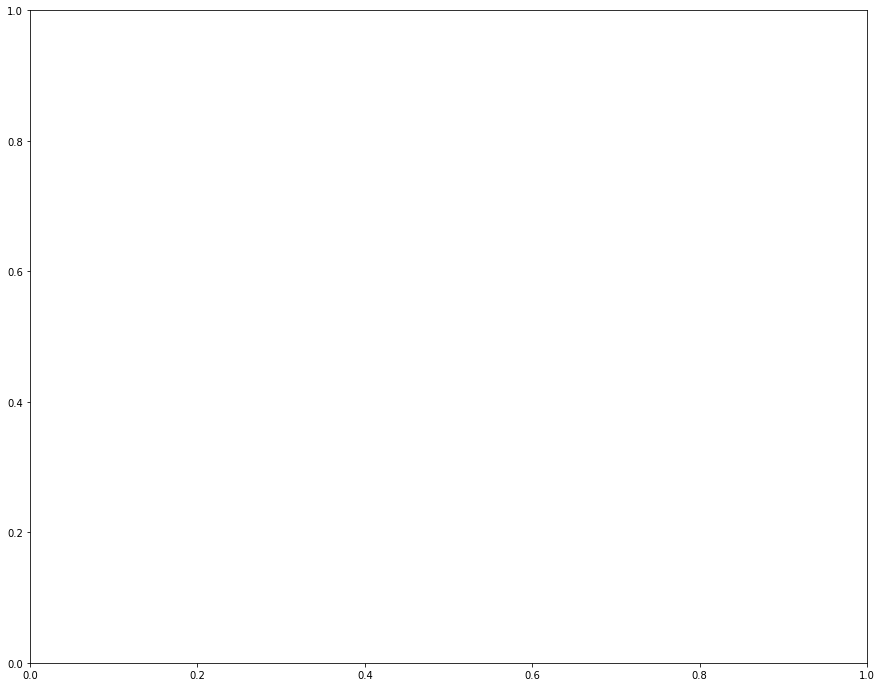

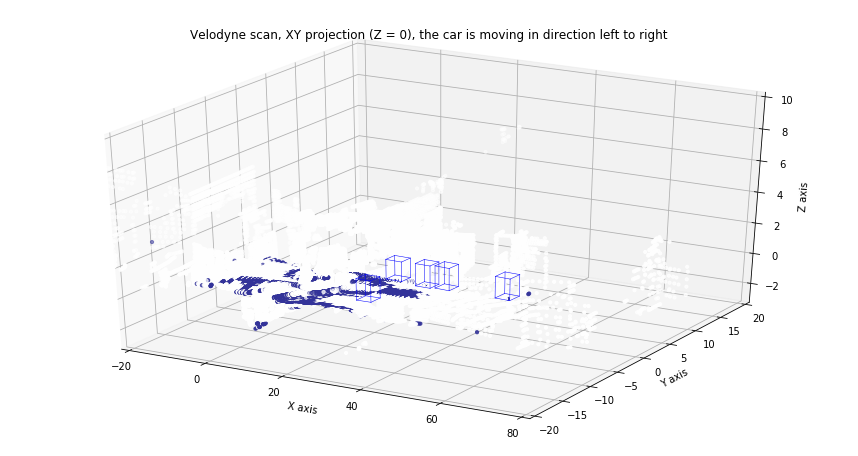

10


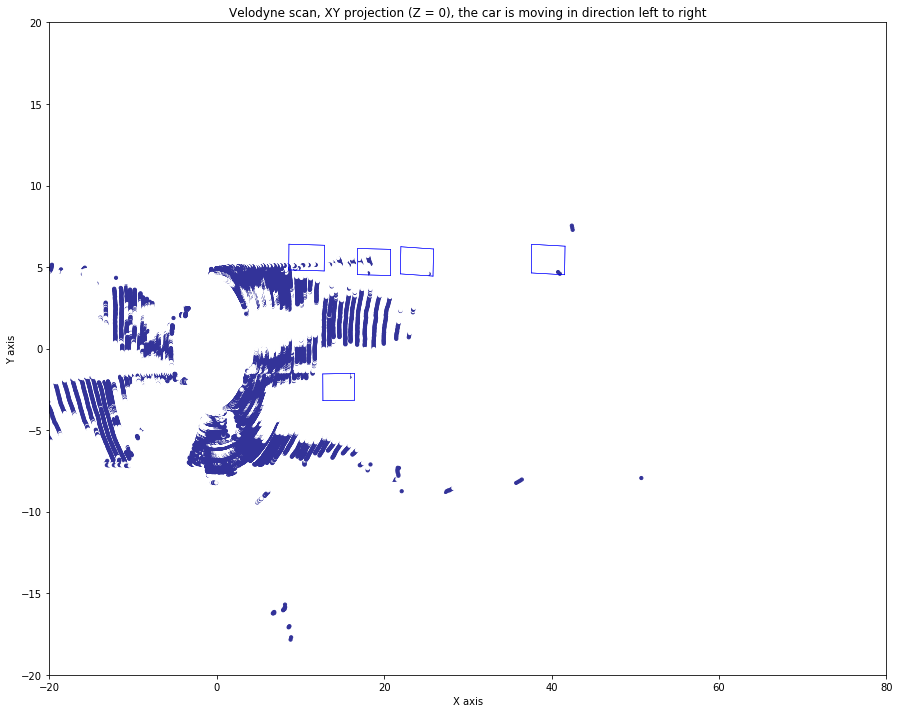

In [53]:
def draw_point_cloud_seg(velo_frame_input,ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    
    point_size = 10
    velo_frame_input
    print(point_size)
    ax.scatter(*np.transpose(velo_frame_input[:, axes]), s=point_size, c=velo_frame_input[:, 3], cmap='terrain')
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    #ax.patch.set_facecolor('black')
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(ax, t_rects, axes=axes, color=colors[t_type])


        
# Draw point cloud data as 3D plot
#f2 = plt.figure(figsize=(15, 8))
#ax2 = f2.add_subplot(111, projection='3d')                    
#draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
#plt.show()

f = plt.figure(figsize=(15, 8))
ax2 = f.add_subplot(111, projection='3d') 

#f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
draw_point_cloud_seg(adj_velo_frame,ax2,'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right')
plt.show()


f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
draw_point_cloud_seg(adj_velo_frame,
    ax3, 
    'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
    axes=[0, 1] # X and Y axes
)
plt.show()

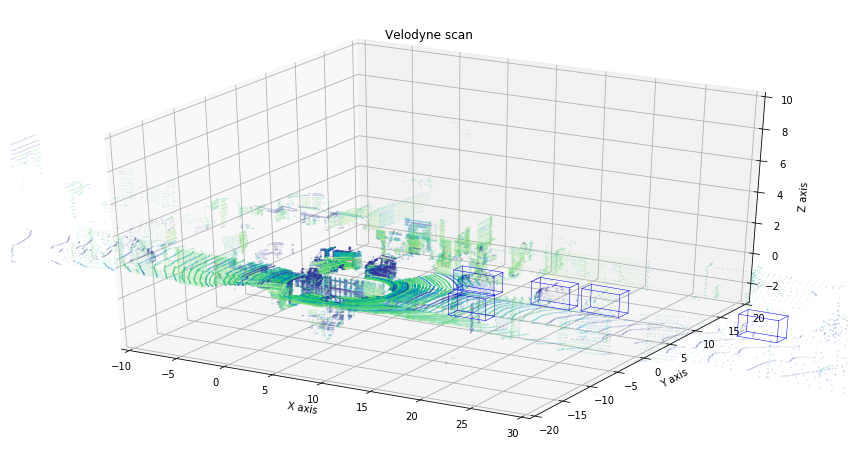

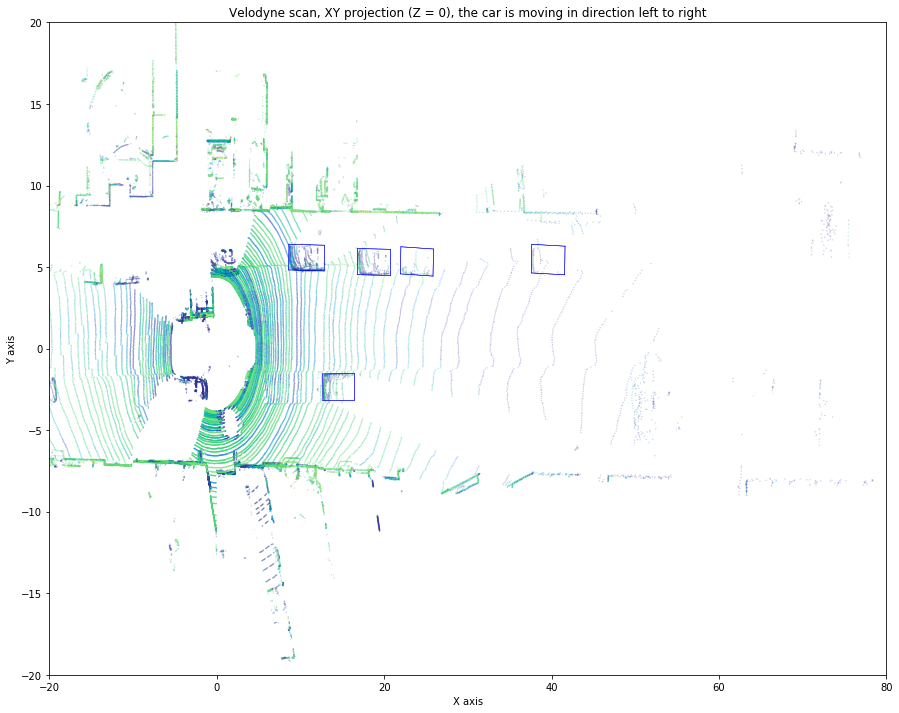

In [18]:
    frame = 10
    dataset_velo = list(dataset.velo)
    points = 0.8 # this controls the sampling rate
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    
    velo_range = range(0, dataset_velo[10].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :] 
    velo_frame_test = velo_frame
    velo_frame_test[:, 3]=velo_frame[:, 3]*10
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]  
    velo_frame = velo_frame_test
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        #ax.patch.set_facecolor('black')
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
    draw_point_cloud(
        ax3, 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    plt.show()

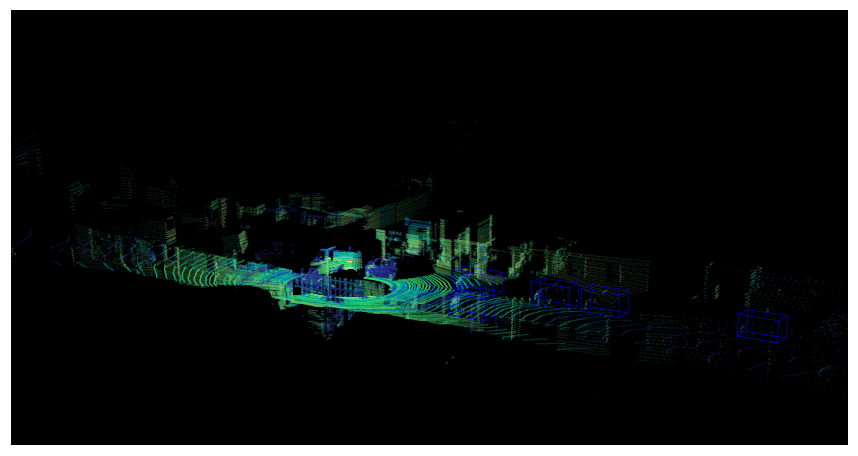

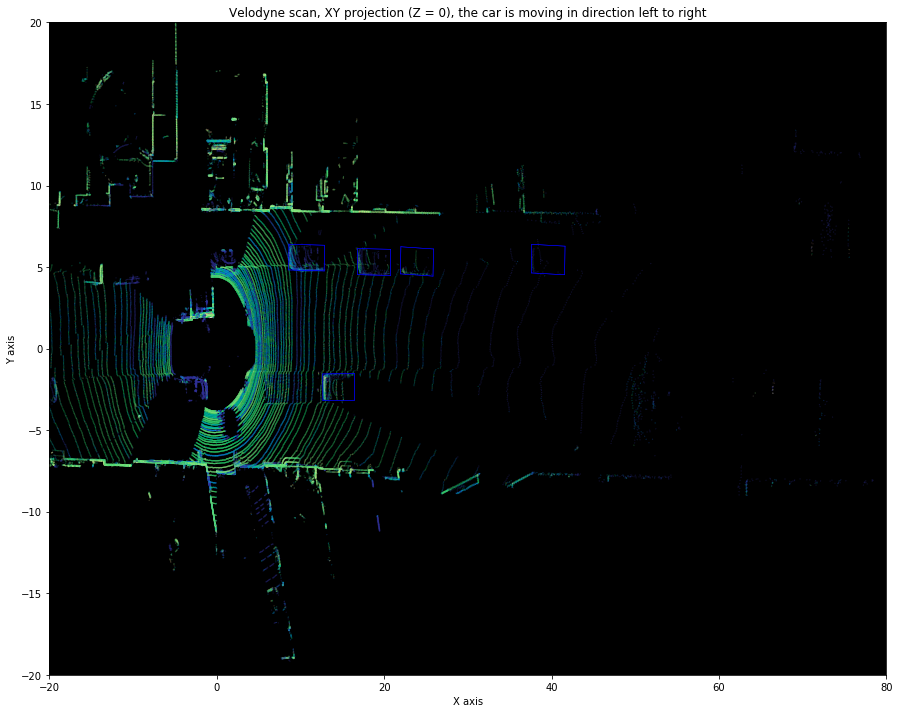

In [19]:
    frame = 10
    dataset_velo = list(dataset.velo)
    points = 0.8 # this controls the sampling rate
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    
    velo_frame_test = velo_frame
    velo_frame_test[:, 3]=velo_frame[:, 3]*10
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]  
    velo_frame = velo_frame_test
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        ax.set_facecolor("black")
        ax.grid(b='off')
        
        #ax.axis(b='off')
        #fig.patch.set_visible(False)
        #ax.patch.set_facecolor('black')
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
            
            # make pane colors transparents
            # these are called axes pane colors. 
            #https://stackoverflow.com/questions/44001613/matplotlip-3d-surface-plot-turn-off-background-but-keep-axes
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    #f2.patch.set_visible(False)
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
    draw_point_cloud(
        ax3, 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    plt.show()

Frame timestamp: 2011-09-26 14:14:11.954821


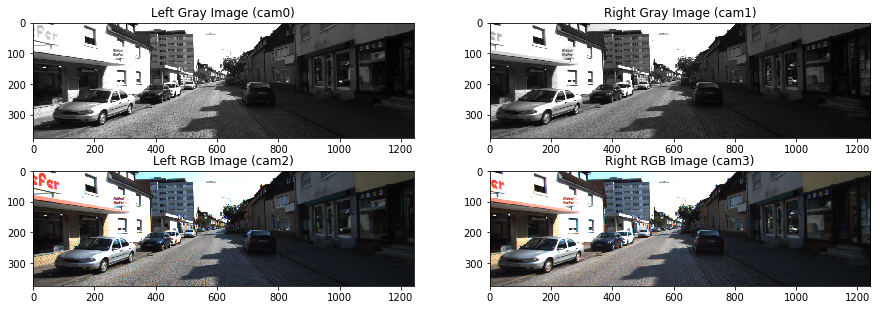

[[<matplotlib.axes._subplots.AxesSubplot object at 0x112dec588>
None


In [20]:
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show() 
    
    print(ax)
    
    print(dataset.frames)

Frame timestamp: 2011-09-26 14:14:10.924614


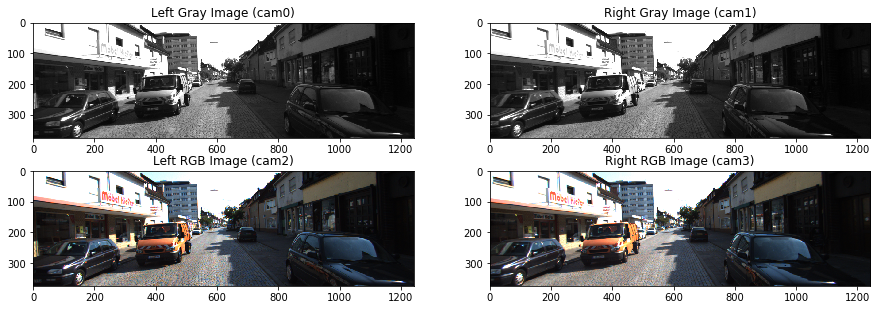

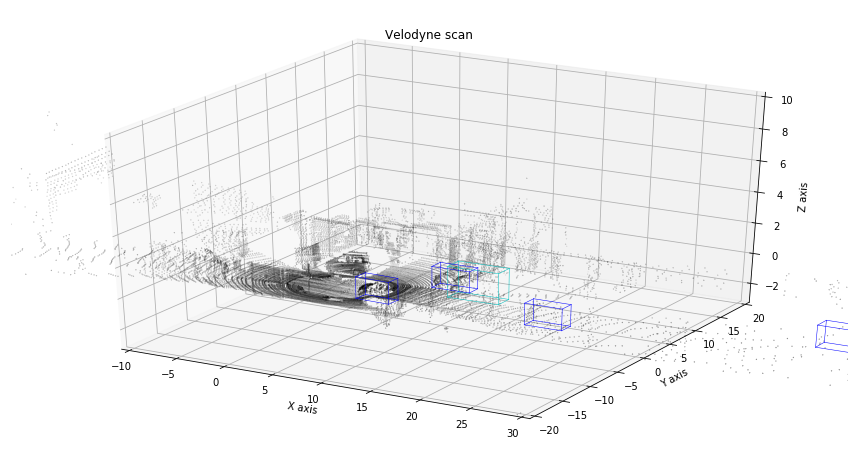

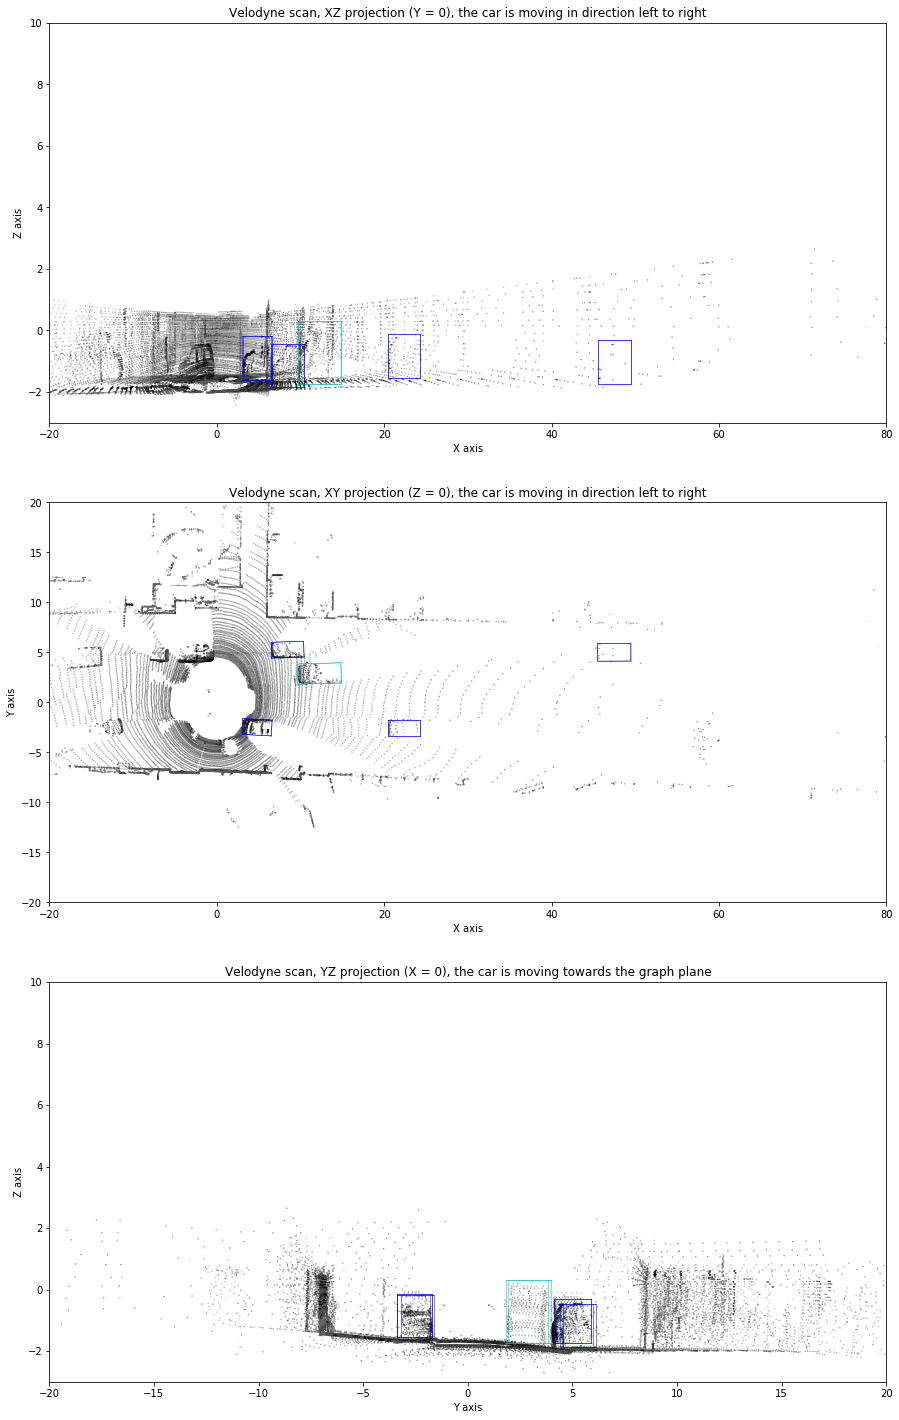

In [21]:
frame = 0

display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame)

In [22]:
from source.utilities import print_progress
from moviepy.editor import ImageSequenceClip

directory = '/home/ubuntu/AI/KITTI-Dataset/'
input_axes=[[0, 1, 2],[1, 2],[0, 1]]
#input_axes=[1, 2]

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types,axes, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    
    axis.set_facecolor("black")
    axis.grid(b='off')

    axis.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    # i think this maybe overlaying it some how. but still making progress on this. at least we know what it does.
    # actually we could reduce the script to this function
    axis.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
    
    # this is for the bounding box
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        #draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
        draw_box(axis, t_rects, axes, color=colors[t_type])
    filename = directory + 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(list(dataset.velo))

n_frames = 10

for a in input_axes:
    print('Preparing animation frames...')
    frames = []
    for i in range(n_frames):
        print_progress(i, n_frames - 1)
        filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types,a)
        frames += [filename]
    print('...Animation frames ready.')

    clip = ImageSequenceClip(frames, fps=5)
    % time
    clip.write_gif('pcl_data{0}.gif'.format(a), fps=5)


Preparing animation frames...
 |----------------------------------------------------------------------------------------------------| 0%

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/AI/KITTI-Dataset/video/frame_0000.png'

In [ ]:
input_axes=[[0, 1, 2],[1, 2],[0, 1]]
print(input_axes)
print(input_axes[1])

range(input_axes)

In [ ]:
#backup

from source.utilities import print_progress
from moviepy.editor import ImageSequenceClip

directory = '/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset'
input_axes=[[0, 1, 2],[1, 2],[0, 1]]
#input_axes=[1, 2]

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types,axes, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='terrain')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    
    axis.set_facecolor("black")
    axis.grid(b='off')

    axis.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    # this is for the bounding box
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        #draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
        draw_box(axis, t_rects, axes, color=colors[t_type])
    filename = directory + 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(list(dataset.velo))

n_frames = 20

for a in input_axes:
    print('Preparing animation frames...')
    frames = []
    for i in range(n_frames):
        print_progress(i, n_frames - 1)
        filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types,a)
        frames += [filename]
    print('...Animation frames ready.')

    clip = ImageSequenceClip(frames, fps=5)
    % time
    clip.write_gif('pcl_data{0}.gif'.format(a), fps=5)
